In [62]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [63]:
root_dir = 'C:/Users/anass/Projects/Computer_Vision/CNN_Classify'
data_dir = root_dir + '/Dataset'
classes = ['positive', 'negative']

for Class in classes:
    train_dir = os.makedirs(data_dir + '/Train/' + Class)
    test_dir = os.makedirs(data_dir + '/Test/' + Class)
    source = data_dir + '/Data/' + Class
    all_files = os.listdir(source)
    np.random.shuffle(all_files)
    test_ratio = 0.15
    train_FileNames, test_FileNames = np.split(np.array(all_files),[int(len(all_files)* (1 - test_ratio))])
    train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]
    for name in train_FileNames:
        shutil.copy(name, data_dir +'/train/' + Class)
    for name in test_FileNames:
        shutil.copy(name, data_dir +'/test/' + Class)


In [64]:
positive_Count = len(os.listdir(data_dir +'/Train/Positive'))
print(positive_Count)

40


In [65]:
Negative_Count = len(os.listdir(data_dir +'/Train/Negative'))
print(Negative_Count)

83


In [66]:
positive_weight = positive_Count / (positive_Count + Negative_Count)
negative_weight = Negative_Count / (positive_Count + Negative_Count)

class_weight = {0: positive_weight, 1: negative_weight}

print(f"Weight for class 0: {negative_weight:.2f}")
print(f"Weight for class 1: {positive_weight:.2f}")

Weight for class 0: 0.67
Weight for class 1: 0.33


In [67]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1, 
    min_delta=0.0001, 
    patience=1, 
    verbose=1
    )

filepath1="learning_weights1.hdf5"
filepath2="learning_weights2.hdf5"

checkpoint1 = ModelCheckpoint(filepath1, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
    )
checkpoint2 = ModelCheckpoint(filepath2, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
    )

In [68]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 15,
                             width_shift_range = 0.1,
                             horizontal_flip = True,
                             zoom_range = 0.2, 
                             shear_range = 0.1, 
                             samplewise_center=True,
                             samplewise_std_normalization=True
                            )

training_set = datagen.flow_from_directory(data_dir + '/Train',
                                           target_size = (128, 128),
                                           batch_size = 16,
                                           class_mode = 'binary',
                                           shuffle = True)
testing_set = datagen.flow_from_directory(data_dir + '/Test',
                                          target_size = (128, 128),
                                          batch_size = 8,
                                          class_mode = 'binary')

Found 123 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


In [69]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))

model1.add(MaxPooling2D(pool_size = (2, 2)))

model1.add(Flatten())

model1.add(Dense(units = 128, activation = 'relu'))

model1.add(Dropout(0.1))

model1.add(Dense(units = 1, activation = 'sigmoid'))

model1.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 127008)            0         
                                                                 
 dense_12 (Dense)            (None, 128)               16257152  
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                      

In [70]:
model_data1 = model1.fit(training_set,
                       steps_per_epoch = 7, 
                       epochs = 30, 
                       validation_data = testing_set, 
                       validation_steps = 2,
                       class_weight = class_weight,
                       verbose = 1,
                       callbacks = [checkpoint1, lr_reduce],
                       )

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 5.4638 - accuracy: 0.4673
Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to learning_weights1.hdf5
7/7 [==============================] - 7s 826ms/step - loss: 5.4638 - accuracy: 0.4673 - val_loss: 3.9584 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 1.6680 - accuracy: 0.5804
Epoch 2: val_accuracy improved from 0.37500 to 0.50000, saving model to learning_weights1.hdf5
7/7 [==============================] - 5s 701ms/step - loss: 1.6680 - accuracy: 0.5804 - val_loss: 1.6125 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.7932 - accuracy: 0.5981
Epoch 3: val_accuracy did not improve from 0.50000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
7/7 [==============================] - 4s 649ms/step - loss: 0.7932 - accuracy: 0.5981 - val_loss: 1.2045 - val_accuracy: 0.

In [71]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))

model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))

model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Flatten())

model2.add(Dense(units = 128, activation = 'relu'))

model1.add(Dropout(0.1))

model2.add(Dense(units = 1, activation = 'sigmoid'))

model2.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 57600)             0         
                                                                 
 dense_14 (Dense)            (None, 128)              

In [72]:
model_data2 = model2.fit(training_set,
                       steps_per_epoch = 7, 
                       epochs = 30, 
                       validation_data = testing_set, 
                       validation_steps = 2,
                       class_weight = class_weight,
                       verbose = 1,
                       callbacks = [checkpoint2, lr_reduce],
                       )

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.9854 - accuracy: 0.5234
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to learning_weights2.hdf5
7/7 [==============================] - 6s 787ms/step - loss: 0.9854 - accuracy: 0.5234 - val_loss: 0.6712 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.5794
Epoch 2: val_accuracy improved from 0.62500 to 0.68750, saving model to learning_weights2.hdf5
7/7 [==============================] - 4s 649ms/step - loss: 0.2961 - accuracy: 0.5794 - val_loss: 0.6770 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.7009
Epoch 3: val_accuracy did not improve from 0.68750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
7/7 [==============================] - 4s 516ms/step - loss: 0.2973 - accuracy: 0.7009 - val_loss: 0.6537 - val_accuracy: 0.

Text(0.5, 1.0, 'Accuracy Evolution')

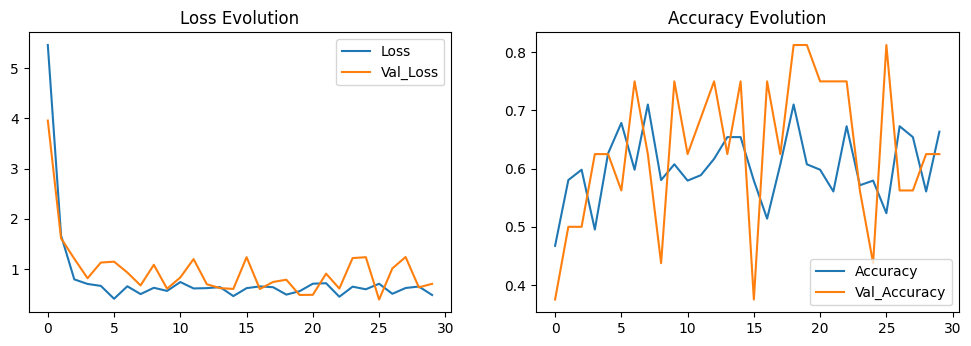

In [73]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model_data1.history['loss'], label='Loss')
plt.plot(model_data1.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(model_data1.history['accuracy'], label='Accuracy')
plt.plot(model_data1.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

Text(0.5, 1.0, 'Accuracy Evolution')

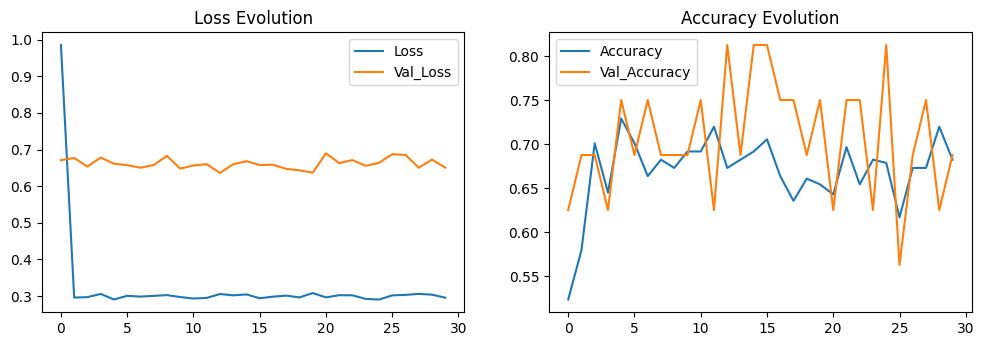

In [74]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(model_data2.history['loss'], label='Loss')
plt.plot(model_data2.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(model_data2.history['accuracy'], label='Accuracy')
plt.plot(model_data2.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
model1.evaluate(testing_set)
model2.evaluate(testing_set)

model1.evaluate(training_set)
model2.evaluate(training_set)

8/8 [==============================] - 3s 303ms/step - loss: 0.6770 - accuracy: 0.6260


[0.6770465970039368, 0.6260162591934204]

In [193]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [270]:
pred1 = model1.predict(testing_set)

3/3 [==============================] - 1s 144ms/step


In [264]:
pred2 = model2.predict(testing_set)

3/3 [==============================] - 1s 103ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.700000,0.666667,0.695652,0.683333,0.688406
recall,0.933333,0.250000,0.695652,0.591667,0.695652
f1-score,0.800000,0.363636,0.695652,0.581818,0.648221
support,15.000000,8.000000,0.695652,23.000000,23.000000


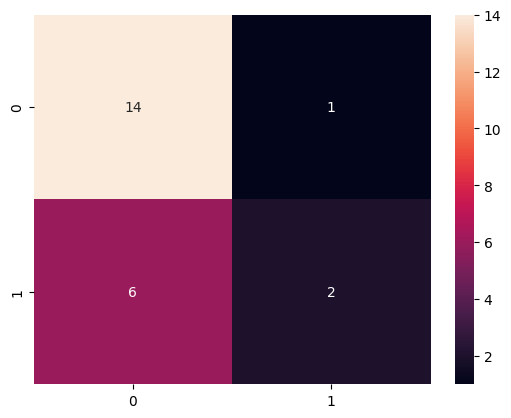

In [271]:
sns.heatmap(confusion_matrix(testing_set.classes, pred1 > 0.5), annot=True)
pd.DataFrame(classification_report(testing_set.classes, pred1 > 0.5, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.714286,1.00,0.73913,0.857143,0.813665
recall,1.000000,0.25,0.73913,0.625000,0.739130
f1-score,0.833333,0.40,0.73913,0.616667,0.682609
support,15.000000,8.00,0.73913,23.000000,23.000000


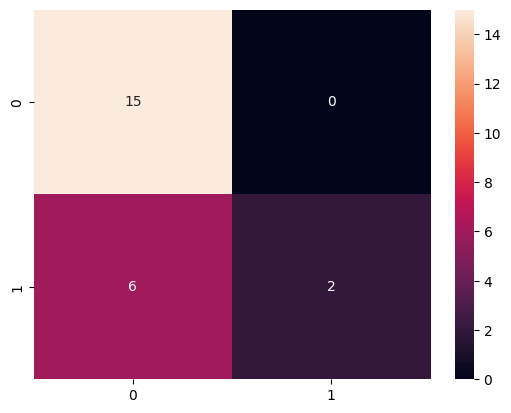

In [265]:
sns.heatmap(confusion_matrix(testing_set.classes, pred2 > 0.5), annot=True)
pd.DataFrame(classification_report(testing_set.classes, pred2 > 0.5, output_dict=True))

In [234]:
pred3 = model1.predict(training_set)
pred4 = model2.predict(training_set)

8/8 [==============================] - 2s 293ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.679012,0.333333,0.560976,0.506173,0.566596
recall,0.662651,0.350000,0.560976,0.506325,0.560976
f1-score,0.670732,0.341463,0.560976,0.506098,0.563653
support,83.000000,40.000000,0.560976,123.000000,123.000000


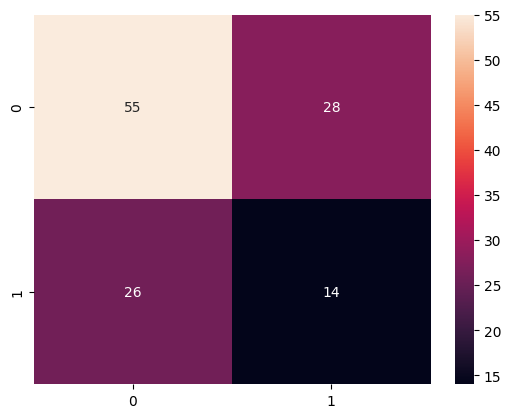

In [235]:
sns.heatmap(confusion_matrix(training_set.classes, pred3 > 0.5), annot=True)
pd.DataFrame(classification_report(training_set.classes, pred3 > 0.5, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.680851,0.344828,0.601626,0.512839,0.571575
recall,0.771084,0.250000,0.601626,0.510542,0.601626
f1-score,0.723164,0.289855,0.601626,0.506509,0.582250
support,83.000000,40.000000,0.601626,123.000000,123.000000


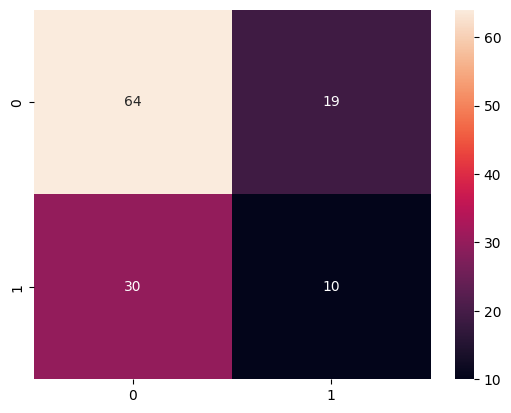

In [236]:
sns.heatmap(confusion_matrix(training_set.classes, pred4 > 0.5), annot=True)
pd.DataFrame(classification_report(training_set.classes, pred4 > 0.5, output_dict=True))